### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [6]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
model_path = base_path + "model_runs/elife_resub/"
load_name = "sust_trans_range"  

with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
    data = unpack_hdf(f)

first_cond = list(data[0].keys())[0]
print("params condition: %s" % first_cond)
model_params = {i: json.loads(d[first_cond]["model_params"]) for i, d in data.items()}
exp_params = {i: json.loads(d[first_cond]["exp_params"]) for i, d in data.items()}
exps = {i: {k: v["data"] for k, v in d.items()} for i, d in data.items()}

for i in exps.keys():
    for cond in exps[i].keys():
        exps[i][cond]["combined_bps"] = {
            n: {
                m: np.sum(
                    [bp[m] for bps in sac.values() for bp in bps.values()], axis=0
                )
                for m in ["g", "i"]
            }
            for n, sac in exps[i][cond]["bps"].items()
        }
        exps[i][cond]["combined_gaba"] = {
            n: {
                m: np.sum([syn[m] for syn in sac.values()], axis=0)
                for m in ["g", "i"]
            }
            for n, sac in exps[i][cond]["gaba"].items()
        }

avg_exps = {i: apply_to_data(lambda a: np.mean(a, axis=0), e) for i, e in exps.items()}

params condition: control


In [7]:
# json.loads(data[0]["uniform"]["model_params"])

### Common axes, labels, and parameters generated or pulled from the control experiment data which apply to all conditions

In [8]:
dt = exp_params[0]["dt"]
rec_xaxis = np.arange(0, exp_params[0]["tstop"] + dt, dt)
velocities = exp_params[0]["velocities"]

### Experiment dict contents / shapes

In [9]:
print("Electrode recording dict keys:", [k for k in exps[0][first_cond]["soma"]["a"].keys()])
print("Synapse recording dict keys:", [k for k in exps[0][first_cond]["gaba"]["a"].keys()])
print("Recording shape:", exps[0][first_cond]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['cai', 'ica', 'v']
Synapse recording dict keys: [0, 1, 2, 3, 4]
Recording shape: (10, 10, 6001)


<IPython.core.display.Javascript object>


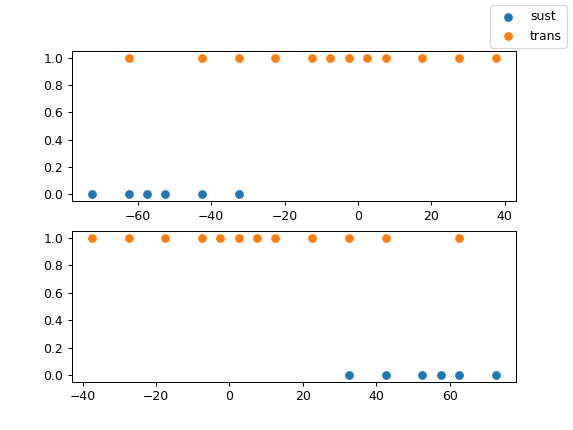

In [10]:
exp_idx = 0
ff, aa = plt.subplots(2)
a_locs = model_params[exp_idx]["a"]["bp_xy_locs"]
b_locs = model_params[exp_idx]["b"]["bp_xy_locs"]
aa[0].scatter(a_locs["sust"]["x"], a_locs["sust"]["y"] , label="sust")
aa[0].scatter(a_locs["trans"]["x"], np.array(a_locs["trans"]["y"]) + 1, label="trans")
aa[1].scatter(b_locs["sust"]["x"], b_locs["sust"]["y"])
aa[1].scatter(b_locs["trans"]["x"], np.array(b_locs["trans"]["y"]) + 1)
ff.legend()

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [12]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["term"]["a"]["v"]),
                peak_vm_deflection(exp["term"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["term"]["a"]["v"], thresh),
                thresholded_area(exp["term"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["term"]["a"]["ica"] * -1, axis=-1),
                np.sum(exp["term"]["b"]["ica"] * -1, axis=-1)
            ),
            "gaba": pn_dsi(
                np.sum(exp["combined_gaba"]["b"]["g"], axis=-1), 
                np.sum(exp["combined_gaba"]["a"]["g"], axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["term"]["a"]["cai"], axis=-1),
                np.max(exp["term"]["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in exps.items()
}

avg_dsis = {
    cond: {
        metric: np.mean([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

### Velocity Tuning of PN DSi
The above measurements of PN DSi for each of the experimental conditions.
- **control:** sustained-transient bipolar time constants and reciprocal GABA are intact
- **no_gaba:** bipolar mechanism remains, while GABA synapses are removed
- **uniform:** bipolar time constants are all the same (no prox-distal difference)
- **no_mechs:** bipolar time constants are uniform, and GABA synapses are removed

<IPython.core.display.Javascript object>


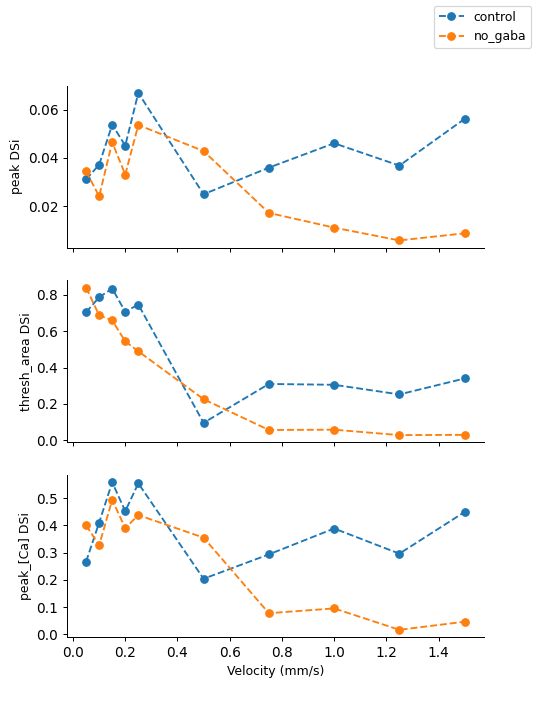

In [13]:
# show_metrics = list(avg_dsis[first_cond].keys())
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
dsi_fig, dsi_ax = plt.subplots(len(show_metrics), sharex=True, figsize=(6, 8))
for (cond, ds) in avg_dsis.items():
    for i, (a, m) in enumerate(zip(dsi_ax, show_metrics)):
        lbl = {"label": cond} if not i else {}  # only add label once for each condition
        a.plot(velocities, np.mean(ds[m], axis=0), linestyle="--", marker="o", **lbl)

for a, metric in zip(dsi_ax, show_metrics):
    a.set_ylabel("%s DSi" % metric)
#     a.set_ylim(0)
    clean_axes(a)

dsi_ax[-1].set_xlabel("Velocity (mm/s)")
dsi_fig.legend()
dsi_fig.show()

<IPython.core.display.Javascript object>


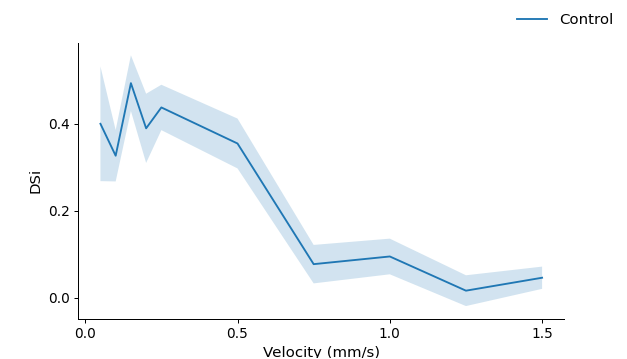

In [17]:
no_gaba_mean = np.mean(avg_dsis["no_gaba"]["peak_[Ca]"], axis=0)
no_gaba_std = np.std(avg_dsis["no_gaba"]["peak_[Ca]"], axis=0)
no_gaba_ste = no_gaba_std / np.sqrt(avg_dsis["no_gaba"]["peak_[Ca]"].shape[0])
no_mechs_mean = np.mean(avg_dsis["no_mechs"]["peak_[Ca]"], axis=0)
no_mechs_std = np.std(avg_dsis["no_mechs"]["peak_[Ca]"], axis=0)
no_mechs_ste = no_mechs_std / np.sqrt(avg_dsis["no_mechs"]["peak_[Ca]"].shape[0])

peak_ca_fig, peak_ca_ax = plt.subplots(1, figsize=(7, 4))
peak_ca_ax.fill_between(velocities, no_gaba_mean + no_gaba_std, no_gaba_mean - no_gaba_std, alpha=0.2)
peak_ca_ax.fill_between(velocities, no_gaba_mean + no_gaba_ste, no_gaba_mean - no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_mean, label="Control")
peak_ca_ax.fill_between(velocities, no_mechs_mean + no_mechs_ste, no_mechs_mean - no_mechs_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_mechs_mean, label="All transient")

peak_ca_ax.set_ylabel("DSi", fontsize=12)
peak_ca_ax.set_xlabel("Velocity (mm/s)", fontsize=12)
peak_ca_ax.set_xticks([0., 0.5, 1., 1.5])
peak_ca_ax.set_yticks([0., 0.2, 0.4])
clean_axes(peak_ca_ax)
peak_ca_fig.legend(fontsize=12, frameon=False)
peak_ca_fig.show()

peak_ca_fig.savefig(os.path.join(base_path, "velocity_falloff_kv3.svg"), bbox_inches="tight")

### Highlight of the thresholded area metric

<IPython.core.display.Javascript object>


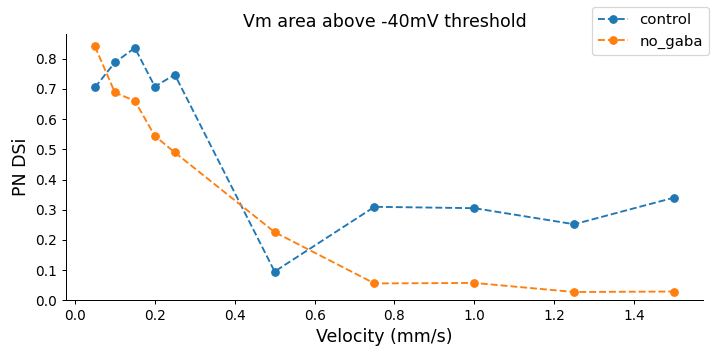

In [18]:
start_vel_idx = 0
end_vel_idx = None
area_dsi_fig, area_dsi_ax = plt.subplots(1, figsize=(8, 4))
for (cond, ds) in avg_dsis.items():
    area_dsi_ax.plot(
        velocities[start_vel_idx:end_vel_idx], 
        np.mean(ds["thresh_area"][:, start_vel_idx:end_vel_idx], axis=0),
        linestyle="--",
        marker="o",
        label=cond
    )

area_dsi_ax.set_title("Vm area above %imV threshold" % thresh, fontsize=14)
area_dsi_ax.set_ylabel("PN DSi", fontsize=14)
area_dsi_ax.set_xlabel("Velocity (mm/s)", fontsize=14)
area_dsi_ax.set_ylim(0)
clean_axes(area_dsi_ax)
area_dsi_fig.legend(fontsize=12)
area_dsi_fig.tight_layout()
area_dsi_fig.show()

In [25]:
# cond = "control"
cond = "no_gaba"
if "vc" in exps[0][cond]:
    avg_vc_i = np.mean(exps[0][cond]["vc"]["a"], axis=0)
    
    vel_idxs = [0, -1]
    all_soma_vci_avg_fig, all_soma_vci_avg_ax = plt.subplots(1)
    for i in vel_idxs:
        all_soma_vci_avg_ax.plot(rec_xaxis, avg_vc_i[i], alpha=0.5)
        
    all_soma_vci_avg_ax.set_xlim(0)
    all_soma_vci_avg_ax.set_ylabel("clamp current (nA)")
    all_soma_vci_avg_ax.set_xlabel("Time (ms)")
    all_soma_vci_avg_fig.show()

<IPython.core.display.Javascript object>


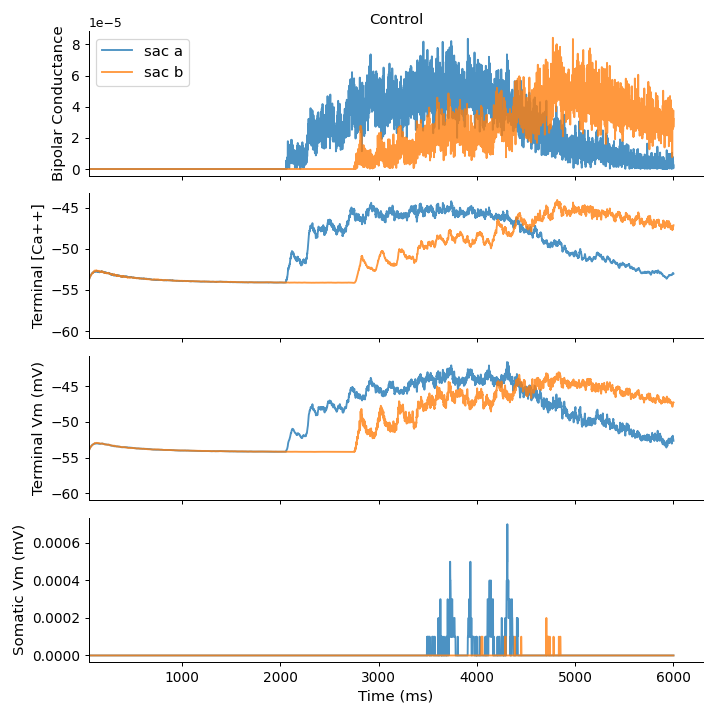

In [30]:
exp_idx = 0
vel_idx = 0
display_conds = ["no_gaba", "no_mechs"]
cond_to_title = {"no_gaba": "Control", "no_mechs": "All Transient"}

ex_fig, ex_ax = plt.subplots(
    4,
    len(display_conds),
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)
ex_ax = np.expand_dims(ex_ax, 1) if len(display_conds) == 1 else ex_ax

for i, cond in enumerate(display_conds):
    if not i:
        ex_ax[0][i].set_ylabel("Bipolar Conductance", fontsize=12)
        ex_ax[1][i].set_ylabel("Terminal [Ca++]", fontsize=12)
        ex_ax[2][i].set_ylabel("Terminal Vm (mV)", fontsize=12)
        ex_ax[3][i].set_ylabel("Somatic Vm (mV)", fontsize=12)
    
    for n in exps[exp_idx][cond]["term"].keys():
        lbl = "sac %s" % n
        ex_ax[0][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["combined_bps"][n]["g"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[1][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["soma"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        ) 
        ex_ax[2][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[3][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["cai"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
    ex_ax[0][i].set_title(cond_to_title[cond])
    ex_ax[-1][i].set_xlabel("Time (ms)", fontsize=12)

for row in ex_ax:
    for col in row:
        clean_axes(col)
        
for ax in ex_ax[-1]:
    ax.set_xlim(50)
    
ex_ax[0][0].legend(fontsize=12)
ex_fig.tight_layout()
ex_fig.show()